In [1]:
using PyPlot
using Plots
using PyCall
using LinearAlgebra
anim =  pyimport("matplotlib.animation");

#TO DO:
- warunki brzegowe dla potencjału (i pola E)? -> + periodic
- usuwanie cząsteczek wypadających poza siatkę -> + (zawijanie)
- warunek stopu dla gaussa-seidla i sprawdzanie zbieżności? -> +
- ograniczenia dla Δx, Δy, Δz i Δt
- problem dwóch strumieni - losowe generowanie cząsteczek
- leapfrog w update velocity?

In [2]:
Base.@kwdef mutable struct Particle
    x::Array{Float64,1} = [0,0,0]
    v::Array{Float64,1} = [0,0,0]
    q::Float64 = 0
    m::Float64 = 0
    c::Int32 = 0
    e::Array{Float64,1} = [0,0,0]
    b::Array{Float64,1} = [0,0,0]
end

Particle

In [3]:
ε_0 = 8.85418781e-12 # vacuum permittivity F/m
c   = 299_792_458. # speed of light m/s
q_e = -1.60217662e-19 # charge of electron C = A*s
m_e = 9.10938356e-31 # mass of electron kg

X=2
Y=1
Z=1
Δx = 5e-2 # 0.05 m
Δy = 5e-2
Δz = 5e-2
Δt = 1e-9 # 1 ns
gsize = [ceil(Int,X/Δx), ceil(Int,Y/Δy), ceil(Int,Z/Δz)] #size of grid
Ex = zeros(Float64, gsize[1],gsize[2],gsize[3])
Ey = zeros(Float64, gsize[1],gsize[2],gsize[3])
Ez = zeros(Float64, gsize[1],gsize[2],gsize[3])

ρ = zeros(Float64, gsize[1],gsize[2],gsize[3]) #charge in grid nodes
d = zeros(Float64, gsize[1],gsize[2],gsize[3]) #charge density in grid nodes
e = zeros(Float64, gsize[1],gsize[2],gsize[3]) #electric field in grid nodes
b = zeros(Float64, gsize[1],gsize[2],gsize[3]) #magnetic field in grid nodes
ϕ = zeros(Float64, gsize[1],gsize[2],gsize[3]) #electric potential
ϕ_old = zeros(Float64, gsize[1],gsize[2],gsize[3])
;

In [4]:
ε_0 = 8.85418781e-12 # vacuum permittivity F/m
c   = 299_792_458. # speed of light m/s
q_e = -1.60217662e-19 # charge of electron C = A*s
m_e = 9.10938356e-31 # mass of electron kg


X=2
Y=1
Z=1
Δx = 5e-2 # 0.05 m
Δy = 5e-2
Δz = 5e-2
Δt = 1e-9 # 1 ns

function generate_grid(XL, YL, ZL, Δx, Δy, Δz)
    gsize = [ceil(Int,XL/Δx), ceil(Int,YL/Δy), ceil(Int,ZL/Δz)]
    Ex = zeros(Float64, gsize[1],gsize[2],gsize[3])
    Ey = zeros(Float64, gsize[1],gsize[2],gsize[3])
    Ez = zeros(Float64, gsize[1],gsize[2],gsize[3])
    
    ρ = zeros(Float64, gsize[1],gsize[2],gsize[3])
    d = zeros(Float64, gsize[1],gsize[2],gsize[3])
    ϕ = zeros(Float64, gsize[1],gsize[2],gsize[3])
    ϕ_old = zeros(Float64, gsize[1],gsize[2],gsize[3])
    return (gsize, Ex, Ey, Ez, ρ, d, ϕ, ϕ_old)
end

gsize, Ex, Ey, Ez, ρ, d, ϕ, ϕ_old = generate_grid(X,Y,Z,Δx,Δy,Δz);

In [5]:
function left_upper_node_for_particle(p)
    i = floor(Int, p.x[1] / Δx) + 1
    j = floor(Int, p.x[2] / Δy) + 1
    k = floor(Int, p.x[3] / Δz) + 1
    return (i,j,k)
end

function get_weights(i,j,k, particle)
    wx = (particle.x[1] - (i-1)*Δx) / Δx
    wy = (particle.x[2] - (j-1)*Δy) / Δy
    wz = (particle.x[3] - (k-1)*Δz) / Δz
    return (wx,wy,wz)
end

get_weights (generic function with 1 method)

In [6]:
#1 depozycja q
function charge_deposition!(ρ, particles)
    @inbounds for p in particles
        i,j,k = left_upper_node_for_particle(p)
        wx,wy,wz = get_weights(i,j,k,p)
        ρ[i,j,k] += (1-wx)*(1-wy)*(1-wz)*p.q
        ρ[i+1,j,k] += (1-wx)*wy*(1-wz)*p.q
        ρ[i+1,j+1,k] += wx*wy*(1-wz)*p.q
        ρ[i+1,j+1,k+1] += wx*wy*wz*p.q
        ρ[i,j+1,k] += wx*(1-wy)*(1-wz)*p.q
        ρ[i,j+1,k+1] += wx*(1-wy)*wz*p.q
        ρ[i,j,k+1] += (1-wx)*(1-wy)*wz*p.q
        ρ[i+1,j,k+1] += (1-wx)*wy*wz*p.q     
    end
    #ładunek z k,j,i = gsize jest dodawany do k,j,i = 1 żeby to periodic działało
    @inbounds for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1)
        ρ[1,j,k] += ρ[gsize[1],j,k]
    end
    @inbounds for i = 1:gsize[1], j = 1:(gsize[2]-1)
        ρ[i,j,1] += ρ[i,j,gsize[3]]
    end
    @inbounds for k = 1:gsize[3], i = 1:gsize[1]
        ρ[i,1,k] += ρ[i,gsize[2],k]
    end
end

function compute_charge_density!(ρ, d)
    @inbounds for i in 1:length(ρ)
        d[i] = ρ[i] / (Δx*Δy*Δz)
    end
end

compute_charge_density! (generic function with 1 method)

In [7]:
#2 obliczenie pola elektrostatycznego -- równanie Poissona
function periodic_boundary_conditions(prev, nxt, i)
    if prev == 0
        prev = gsize[i]-1
    end
    if nxt == gsize[i]
        nxt = 1
    end
    return (prev, nxt)
end

function compute_potential(ϕ, ρ) #gauss-seidl
    max_it = 5000
    L2 = 0
    ω = 1.4
    conv = false
    tolerance = 1e-5
    
    @inbounds for m = 1:max_it
        ϕ_old .= ϕ
        @inbounds for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
            previ, nxti = periodic_boundary_conditions(i-1, i+1, 1)
            prevj, nxtj = periodic_boundary_conditions(j-1, j+1, 2)
            prevk, nxtk = periodic_boundary_conditions(k-1, k+1, 3) 
            ϕ[i,j,k] = ((ϕ[previ,j,k] + ϕ[nxti,j,k])/(Δy^2) + (ϕ[i,prevj,k] + ϕ[i,nxtj,k])/(Δx^2) + (ϕ[i,j,prevk] + ϕ[i,j,nxtk])/(Δz^2) + ρ[i,j,k]/ε_0) / (2/(Δx^2) + 2/(Δy^2) + 2/(Δz^2))

            ϕ[i,j,k] = ϕ_old[i,j,k] + ω*(ϕ[i,j,k] - ϕ_old[i,j,k])
        end

        if m % 25 == 0
            sum = 0
            @inbounds for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
                previ, nxti = periodic_boundary_conditions(i-1, i+1, 1)
                prevj, nxtj = periodic_boundary_conditions(j-1, j+1, 2)
                prevk, nxtk = periodic_boundary_conditions(k-1, k+1, 3)
                r = -ϕ[i,j,k]*(2/(Δx^2) + 2/(Δy^2) + 2/(Δz^2)) + ρ[i,j,k]/ε_0 + (ϕ[previ,j,k] + ϕ[nxti,j,k])/(Δy^2) + (ϕ[i,prevj,k] + ϕ[i,nxtj,k])/(Δx^2) + (ϕ[i,j,prevk] + ϕ[i,j,nxtk])/(Δz^2)
                sum += r^2
            end
            L2 = sqrt(sum / ((gsize[1]-1)*(gsize[2]-1)*(gsize[3]-1)))
            if L2 < tolerance
                conv = true
                break
            end
        end
    end
    @inbounds for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1)
        ϕ[gsize[1],j,k] = ϕ[1,j,k]
    end
    @inbounds for i = 1:gsize[1], j = 1:(gsize[2]-1)
        ϕ[i,j,gsize[3]] = ϕ[i,j,1]
    end
    @inbounds for k = 1:gsize[3], i = 1:gsize[1]
        ϕ[i,gsize[2],k] = ϕ[i,1,k]
    end
    if conv == false
        println("GS failed to converge, L2 = ", L2)
    end
end

function compute_electric_field(Ex,Ey,Ez, ϕ)
    @inbounds for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
        previ, nxti = periodic_boundary_conditions(i-1, i+1, 1)
        prevj, nxtj = periodic_boundary_conditions(j-1, j+1, 2)
        prevk, nxtk = periodic_boundary_conditions(k-1, k+1, 3) 
        Ex[i,j,k] = (ϕ[i,prevj,k] - ϕ[i,nxtj,k])/(2Δx)
        Ey[i,j,k] = (ϕ[previ,j,k]- ϕ[nxti,j,k])/(2Δy)
        Ez[i,j,k] = (ϕ[i,j,prevk] - ϕ[i,j,nxtk])/(2Δz)
    end
    @inbounds for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1)
        Ex[gsize[1],j,k] = Ex[1,j,k]
        Ey[gsize[1],j,k] = Ey[1,j,k]
        Ez[gsize[1],j,k] = Ez[1,j,k]
    end
    @inbounds for i = 1:gsize[1], j = 1:(gsize[2]-1)
        Ex[i,j,gsize[3]] = Ex[i,j,1]
        Ey[i,j,gsize[3]] = Ey[i,j,1]
        Ez[i,j,gsize[3]] = Ez[i,j,1]
    end
    @inbounds for k = 1:gsize[3], i = 1:gsize[1]
        Ex[i,gsize[2],k] = Ex[i,1,k]
        Ey[i,gsize[2],k] = Ey[i,1,k]
        Ez[i,gsize[2],k] = Ez[i,1,k]
    end
end

compute_electric_field (generic function with 1 method)

In [8]:
#4 obliczenie E dla cząsteczek
function interpolate_E_to_particles!(particles, Ex, Ey, Ez, E_ex, B_ex)
    @inbounds for p in particles
        i,j,k = left_upper_node_for_particle(p)
        wx,wy,wz = get_weights(i,j,k,p)
        sum_electric_field!(p, Ex, 1, wx, wy, wz,i,j,k)
        sum_electric_field!(p, Ey, 2, wx, wy, wz,i,j,k)
        sum_electric_field!(p, Ez, 3, wx, wy, wz,i,j,k)
        add_external_E_B!(p, E_ex, B_ex)
    end
end

function sum_electric_field!(p, e, idx, wx, wy, wz,i,j,k)
    p.e[idx] += (1-wx)*(1-wy)*(1-wz)*e[i,j,k]
    p.e[idx] += (1-wx)*wy*(1-wz)*e[i+1,j,k]
    p.e[idx] += wx*wy*(1-wz)*e[i+1,j+1,k]
    p.e[idx] += wx*wy*wz*e[i+1,j+1,k+1]
    p.e[idx] += wx*(1-wy)*(1-wz)*e[i,j+1,k]
    p.e[idx] += wx*(1-wy)*wz*e[i,j+1,k+1]
    p.e[idx] += (1-wx)*(1-wy)*wz*e[i,j,k+1]
    p.e[idx] += (1-wx)*wy*wz*e[i+1,j,k+1]
end

function add_external_E_B!(particle, E_ex, B_ex)
    particle.e .+= E_ex
    particle.b .= B_ex
end

add_external_E_B! (generic function with 1 method)

In [9]:
#5 poruszenie cząsteczek
function periodic_boundary_for_particle!(p)
    if p.x[1] < 0
        p.x[1] += (gsize[1]-1)*Δx
    elseif p.x[1] > (gsize[1]-1)*Δx
        p.x[1] -= (gsize[1]-1)*Δx
    end
    if p.x[2] < 0
        p.x[2] += (gsize[2]-1)*Δy
    elseif p.x[2] > (gsize[2]-1)*Δy
        p.x[2] -= (gsize[3]-1)*Δy
    end
    if p.x[3] < 0
        p.x[3] += (gsize[3]-1)*Δz
    elseif p.x[3] > (gsize[3]-1)*Δz
        p.x[3] -= (gsize[3]-1)*Δz
    end      
end

function boris_pusher!(particles, Δt, c)
    for p in particles
        Q = (q_e*Δt)/(p.m*2)
        u⁻ = p.v + Q*p.e
        u² = dot(u⁻, u⁻)
        c² = c*c
        γ  = sqrt(1. + u²/c²)
        t  = (Q/γ) * p.b
        t² = dot(t, t)
        s = 2.0t / (1. + t²)

        u′ = u⁻ + cross(u⁻, t)
        u⁺ = u⁻ + cross(u′, s)
        
        p.v .= u⁺ + Q * p.e
        p.x += p.v*Δt
        #println("V: ", p.v)
        #println("X: ", p.x)
        periodic_boundary_for_particle!(p)
    end
end

boris_pusher! (generic function with 1 method)

In [10]:
function timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    fill!(ρ, 0)
    fill!(d, 0)
    fill!(ϕ, 0)
    fill!(Ex, 0)
    fill!(Ey, 0)
    fill!(Ez, 0)
    fill!(particles[1].e, 0)
    fill!(particles[1].b, 0)
    charge_deposition!(ρ, particles)
    compute_charge_density!(ρ, d)
    compute_potential(ϕ, ρ) 
    compute_electric_field(Ex,Ey,Ez, ϕ)
    interpolate_E_to_particles!(particles, Ex, Ey, Ez, E_ex, B_ex)
    boris_pusher!(particles, Δt, c)
end


timestep! (generic function with 1 method)

In [10]:
E_ex = [0,0,0]
B_ex = [0,0,6.82272e-5]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = q_e
p1.v = [0, 3e6, 0]
p1.x = [0.75, 0.5, 0.3]
Δt = 1e-9

xx = []
push!(xx, [0.75, 0.5, 0.3])

for i = 1:50
    timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    push!(xx, particles[1].x)
end

In [11]:
v = 3e6
B = 6.82272e-5
r = abs((m_e*v) / (q_e*B))
w = -(q_e*B)/m_e
xx_an = []
push!(xx_an, [0.75, 0.5])
dt = 1e-9 
# l = 2*π*r
# num_steps = 100
# T = l / v
# dt = T / num_steps
# print(dt)
for t in 1:50
    t *= dt
    k = w*t
    x = r * cos(k) - r
    y = r * sin(k)
    push!(xx_an, [0.75, 0.5] + [x, y])
end

In [11]:
function get_num_steps_for_dt(v,B, dt, coef)
    r = abs((m_e*v) / (q_e*B))
    l = 2*π*r
    T = (l*coef) / v
    num_steps = ceil(Int, T / dt)
    return num_steps
end

get_num_steps_for_dt (generic function with 1 method)

In [12]:
function analitical_B(t, b, v, x0, y0)
    r = abs((m_e*v) / (q_e*b))
    w = -(q_e*b)/m_e
    k = w*t
    x = r * cos(k) - r + x0
    y = r * sin(k) + y0
    return [x, y, 0.0]
end

analitical_B (generic function with 1 method)

In [ ]:
#timestep 0,1 1 10
E_ex = [0,0,0]
B_ex = [0,0,6.82272e-5]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = 0
p1.v = [0, 3e6, 0]
p1.x = [0.75, 0.5, 0.0]
Δt = 4.61766e-11
Δt = 1e-9
t = [1e-9, 1e-10, 1e-11, 1e-12]
xx = []
xx_an = []
push!(xx, [0.75, 0.5, 0.0])
push!(xx_an, [0.75, 0.5, 0.0])
xerrors = [0.0]

Δx = 5e-2
Δy = 5e-2
Δz = 5e-2
gsize, Ex, Ey, Ez, ρ, d, ϕ, ϕ_old = generate_grid(2,1,1, Δx,Δy,Δz)

fig = plt.figure()
styles = [(0, (2, 6)),
(2, (2, 8)),
(4, (2, 8)),
(6, (2, 8))]
count = 0

for dt in t
    count += 1
    num_steps = get_num_steps_for_dt(3e6, 6.82272e-5, dt, 1.0)
    println(num_steps)
    for i = 1:num_steps
        if i % 50 == 0
            println("dt ", dt, " step: ", i)
        end
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,dt, c)
        push!(xx, particles[1].x)
        x_an = analitical_B(dt*i, B_ex[3], 3e6, 0.75, 0.5)
        push!(xx_an, x_an)
    end

    plt.figure(figsize=(8,8))
    plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle=styles[count], label="Δt = $(dt) s")
end
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="solid", label="analytic")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
plt.legend()
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
plt.savefig("B_circle.png")

dt 1.0e-9
524
dt 1.0e-9 step: 1
dt 1.0e-9 step: 2
dt 1.0e-9 step: 3
dt 1.0e-9 step: 4
dt 1.0e-9 step: 5
dt 1.0e-9 step: 6
dt 1.0e-9 step: 7
dt 1.0e-9 step: 8
dt 1.0e-9 step: 9
dt 1.0e-9 step: 10
dt 1.0e-9 step: 11
dt 1.0e-9 step: 12
dt 1.0e-9 step: 13
dt 1.0e-9 step: 14
dt 1.0e-9 step: 15
dt 1.0e-9 step: 16
dt 1.0e-9 step: 17
dt 1.0e-9 step: 18
dt 1.0e-9 step: 19
dt 1.0e-9 step: 20
dt 1.0e-9 step: 21
dt 1.0e-9 step: 22
dt 1.0e-9 step: 23
dt 1.0e-9 step: 24
dt 1.0e-9 step: 25
dt 1.0e-9 step: 26
dt 1.0e-9 step: 27
dt 1.0e-9 step: 28
dt 1.0e-9 step: 29
dt 1.0e-9 step: 30
dt 1.0e-9 step: 31
dt 1.0e-9 step: 32
dt 1.0e-9 step: 33
dt 1.0e-9 step: 34
dt 1.0e-9 step: 35
dt 1.0e-9 step: 36
dt 1.0e-9 step: 37
dt 1.0e-9 step: 38
dt 1.0e-9 step: 39
dt 1.0e-9 step: 40
dt 1.0e-9 step: 41
dt 1.0e-9 step: 42
dt 1.0e-9 step: 43
dt 1.0e-9 step: 44
dt 1.0e-9 step: 45
dt 1.0e-9 step: 46
dt 1.0e-9 step: 47
dt 1.0e-9 step: 48
dt 1.0e-9 step: 49
dt 1.0e-9 step: 50
dt 1.0e-9 step: 51
dt 1.0e-9 step: 52
dt 1.0e

In [ ]:
#timestep 0,1 1 10
E_ex = [0,0,0]
B_ex = [0,0,6.82272e-5]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = 0
p1.v = [0, 3e6, 0]
p1.x = [0.75, 0.5, 0.0]
Δt = 4.61766e-11
Δt = 1e-9
t = [1e-9, 1e-10, 1e-11, 1e-12]
xx = []
xx_an = []
push!(xx, [0.75, 0.5, 0.0])
push!(xx_an, [0.75, 0.5, 0.0])
xerrors = [0.0]

Δx = 5e-2
Δy = 5e-2
Δz = 5e-2
gsize, Ex, Ey, Ez, ρ, d, ϕ, ϕ_old = generate_grid(2,1,1, Δx,Δy,Δz)

fig = plt.figure()
styles = [(0, (2, 6)),
(2, (2, 8)),
(4, (2, 8)),
(6, (2, 8))]
count = 0

for dt in t[1]
    count += 1
    num_steps = get_num_steps_for_dt(3e6, 6.82272e-5, dt, 1.1)
    xerrors = [0.0]
    for i = 1:num_steps
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,dt, c)
        push!(xx, particles[1].x)
        x_an = analitical_B(dt*i, B_ex[3], 3e6, 0.75, 0.5)
        dist = (particles[1].x .- x_an)*100
        er = sqrt(dot(dist,dist))
        push!(xerrors, er)
        push!(xx_an, x_an)
    end

    plt.plot(0:dt:dt*num_steps, xerrors, linestyle=styles[count], label="Δt = $(dt) s")
    push!(history, xerrors)
end

plt.xlabel("Time [ns]")
plt.ylabel("Error [cm]")
plt.title("Error due to time step")
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig("Error_time_step_B.png")
plt.yscale("log")
plt.tight_layout()
plt.savefig("Error_time_step_B_lim.png")
println(xerrors)

In [51]:
function get_dt_for_num_steps(v,B, num_steps)
    r = abs((m_e*v) / (q_e*B))
    l = 2*π*r
    T = l / v
    dt = T / num_steps
    return dt
end

get_dt_for_num_steps (generic function with 2 methods)

In [38]:
#timestep 100 - 20 000
E_ex = [0,0,0]
B_ex = [0,0,6.82272e-5]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = q_e
p1.v = [0, 3e6, 0]
p1.x = [0.75, 0.5, 0.3]
xx = []
xx_an = []
push!(xx, [0.75, 0.5, 0.0])
push!(xx_an, [0.75, 0.5, 0.0])
xerrors = [0.0]
num_steps = []
append!(num_steps, 100:100:500)
# append!(num_steps, 2000:1000:10000)
# append!(num_steps, [15000, 20000])
for ns in num_steps
    dt = get_dt_for_num_steps(3e6, 6.82272e-5, ns)
    er = 0
    dist = []
    pos_an = []
    for i = 1:ns
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,dt, c)
        push!(xx, particles[1].x)
        x_an = analitical_B(dt*i, B_ex[3], 3e6, 0.75, 0.5)
        diff = particles[1].x .- x_an
        push!(dist, sqrt(dot(diff,diff)))
        push!(pos_an, x_an)
    end
    L2_dist = sqrt(dot(dist,dist))
    L2_an = sqrt(dot(pos_an,pos_an))
    rel_er = L2_dist / L2_an
    push!(xerrors, rel_er)
end
fig = plt.figure()
plt.figure(figsize=(8,8))
plt.plot(num_steps, xerrors, linestyle="solid",marker='o')
plt.xlabel("Num steps")
plt.ylabel("Error")
plt.grid()
plt.tight_layout()
plt.savefig("Rel_error_b.png")
plt.yscale("log")
plt.xscale("log")
plt.savefig("Rel_error_b_log.png")
;

LoadError: UndefVarError: `get_dt_for_num_steps` not defined

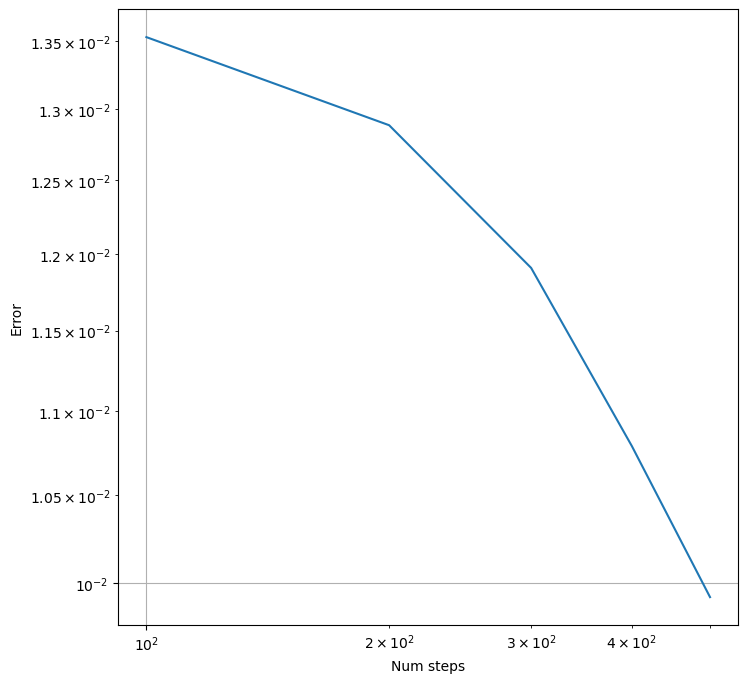

In [56]:
fig = plt.figure()
plt.figure(figsize=(8,8))
plt.plot(num_steps, error, linestyle="solid")
plt.xlabel("Num steps")
plt.ylabel("Error")
plt.grid()
plt.yscale("log")
plt.xscale("log")
;

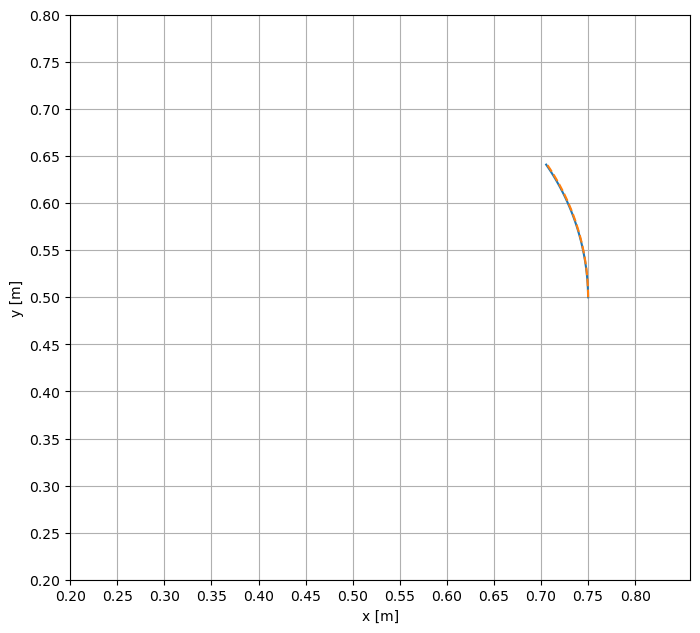

In [12]:
#plt.plot(1:10, [x[1]*100 for x in xx])
plt.figure(figsize=(8,8))
plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle="solid")
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
#plt.axis([0.2, 0.8, 0.2, 0.8])
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

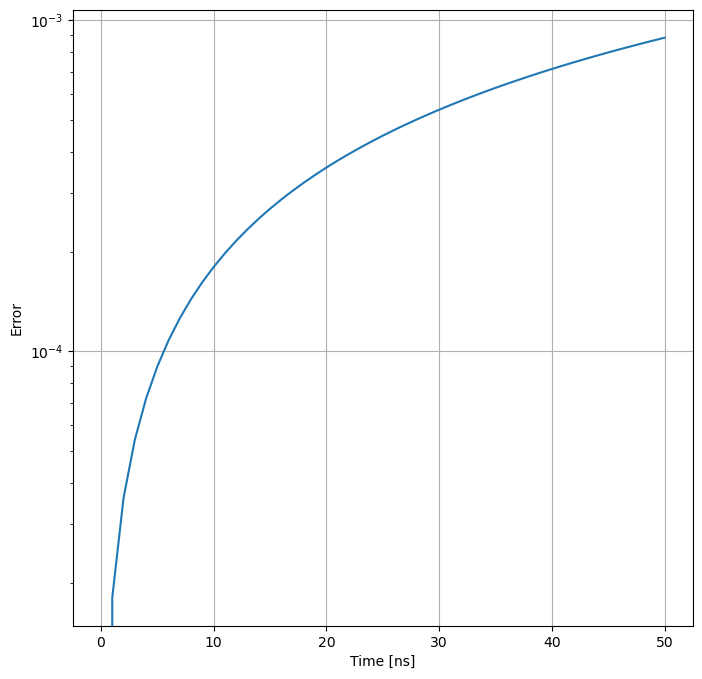

In [44]:
fig = plt.figure()
plt.figure(figsize=(8,8))
plt.plot(0:50, error, linestyle="solid")
plt.xlabel("Time [ns]")
plt.ylabel("Error")
plt.grid()
plt.yscale("log")
;

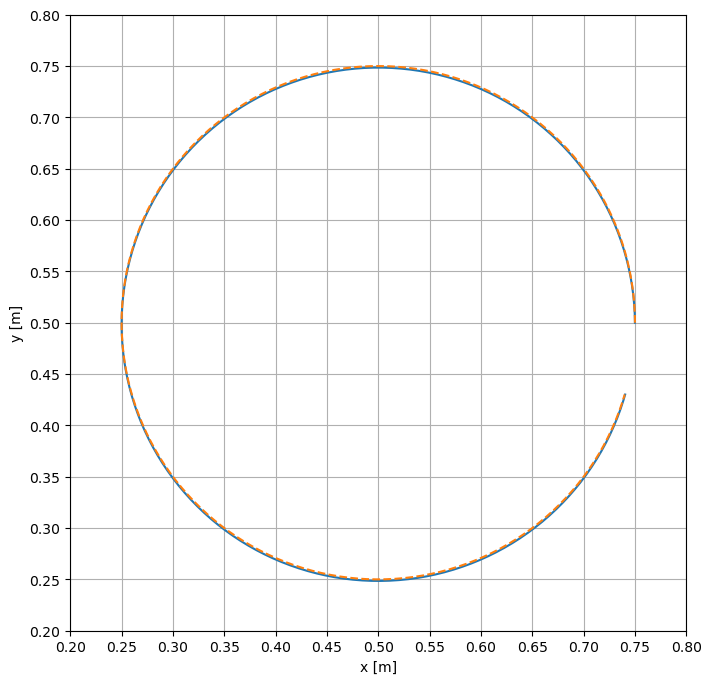

In [117]:
#plt.plot(1:10, [x[1]*100 for x in xx])
plt.figure(figsize=(8,8))
plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle="solid")
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
#plt.axis([0.2, 0.8, 0.2, 0.8])
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

5.236015443404827e-9

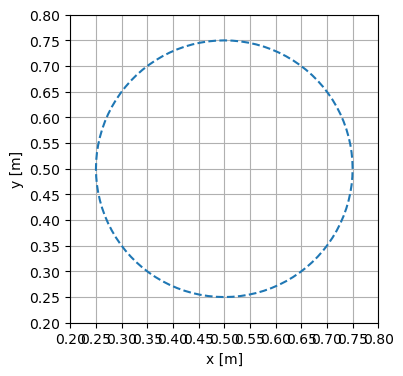

In [49]:
v = 3e6
B = 6.82272e-5
r = abs((m_e*v) / (q_e*B))
w = -(q_e*B)/m_e
xx_an = []
push!(xx_an, [0.75, 0.5])
l = 2*π*r
num_steps = 100
T = l / v
dt = T / num_steps
print(dt)
for t in 1:100
    t *= dt
    k = w*t
    x = r * cos(k) - r
    y = r * sin(k)
    push!(xx_an, [0.75, 0.5] + [x, y])
end

fig = plt.figure()
plt.figure(figsize=(4,4))
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

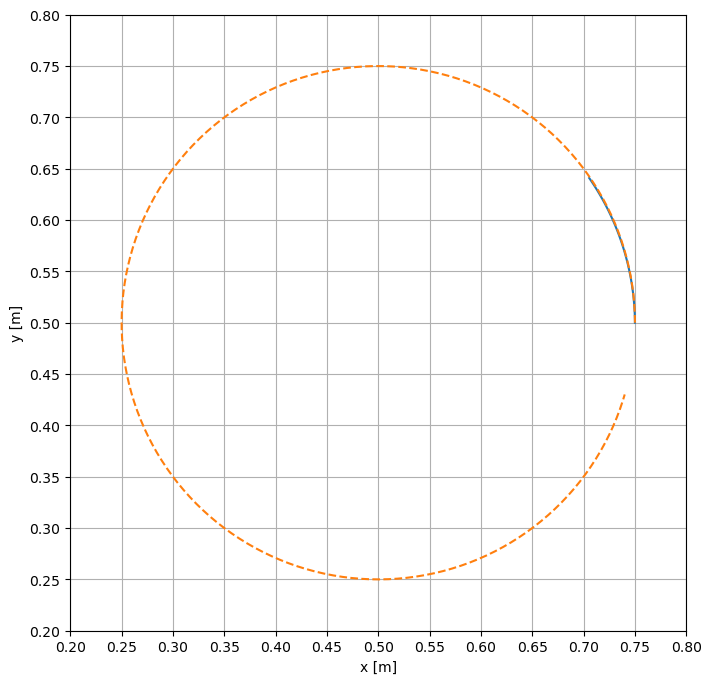

In [26]:
#plt.plot(1:10, [x[1]*100 for x in xx])
plt.figure(figsize=(8,8))
plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle="solid")
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
#plt.axis([0.2, 0.8, 0.2, 0.8])
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

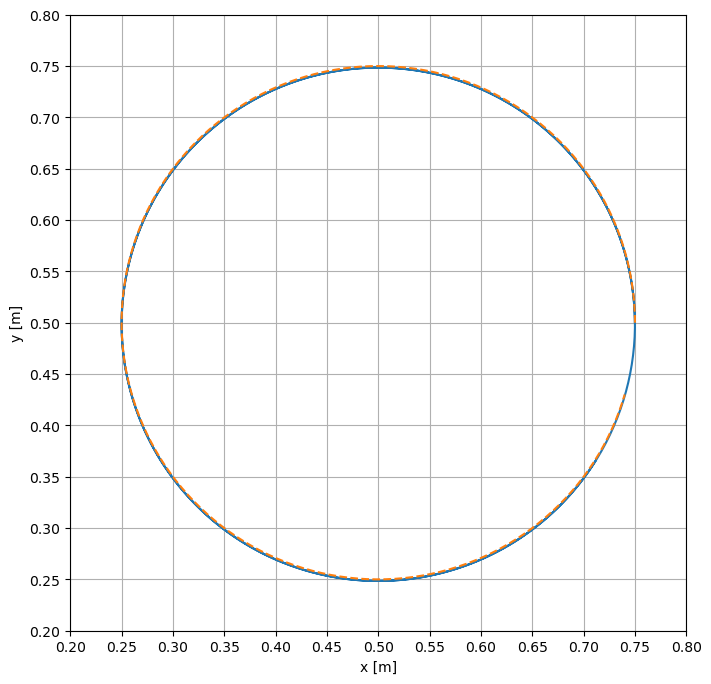

In [19]:
#plt.plot(1:10, [x[1]*100 for x in xx])
plt.figure(figsize=(8,8))
plt.plot([x[1] for x in xx], [x[2] for x in xx],linestyle="solid")
plt.plot([x[1] for x in xx_an], [x[2] for x in xx_an],linestyle="dashed")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("square")
plt.grid()
#plt.axis([0.2, 0.8, 0.2, 0.8])
plt.xticks(0.2:0.05:0.8)
plt.yticks(0.2:0.05:0.8)
;

In [34]:
#+ pomiar czasu

E_ex = [-1,0,0]
B_ex = [0,0,0]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = q_e
p1.x = [0,0,0]
p1.v = [0,0,0]
Δt = 1e-10
t = [1e-9, 1e-10, 1e-11, 1e-12]
tt = 5e-9
times = [tt/dt for dt in t]
Δx = 5e-2
Δy = 5e-2
Δz = 5e-2
gsize, Ex, Ey, Ez, ρ, d, ϕ, ϕ_old = generate_grid(2,1,1, Δx,Δy,Δz)
xerrors = [0.0]
for dt in t
    vel = []
    xx = []
    xx_an = []
    vel_an = []
    push!(vel, [0,0,0])
    push!(xx, [0,0,0])
    push!(vel_an, [0,0,0])
    push!(xx_an, [0,0,0])
    xerrors = [0.0]
    particles[1].x = [0,0,0]
    particles[1].v = [0,0,0]
    for i = 1:tt/dt
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,dt, c)
        push!(vel, particles[1].v)
        push!(xx, particles[1].x)
        va = (q_e/m_e) * E_ex * dt*i
        xa = 0.5*(q_e/m_e) * E_ex * (dt*i)^2
        push!(vel_an, va)
        push!(xx_an, xa)
    
        diff = particles[1].x .- xa
        er = sqrt(dot(diff, diff))
        push!(xerrors, er)
    end
    fig = plt.figure()
    plt.plot(0:(dt*1e9):5, [x[1]*100 for x in xx], linestyle="solid", label="simulation")
    plt.plot(0:(dt*1e9):5, [x[1]*100 for x in xx_an], linestyle="dashed", label="analytic")
    plt.grid()
    plt.legend()
    plt.xlabel("Time [ns]")
    plt.ylabel("x [cm]")
    plt.title("Time step = $(dt) s")
    plt.tight_layout()
    plt.savefig("Eex_step_$(dt).png")
end

history = []
xerrors = [0.0]
fig = plt.figure()
for dt in t
    vel = []
    xx = []
    xx_an = []
    vel_an = []
    push!(vel, [0,0,0])
    push!(xx, [0,0,0])
    push!(vel_an, [0,0,0])
    push!(xx_an, [0,0,0])
    particles[1].x = [0,0,0]
    particles[1].v = [0,0,0]
    xerrors = [0.0]
    for i = 1:tt/dt
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,dt, c)
        push!(vel, particles[1].v)
        push!(xx, particles[1].x)
        va = (q_e/m_e) * E_ex * dt*i
        xa = 0.5*(q_e/m_e) * E_ex * (dt*i)^2
        push!(vel_an, va)
        push!(xx_an, xa)
    
        diff = (particles[1].x .- xa).*100
        er = sqrt(dot(diff, diff))
        push!(xerrors, er)
    end
    plt.plot(0:(dt*1e9):5.0, xerrors, linestyle="solid", label="Δt = $(dt)")
    push!(history, xerrors[1:(floor(Int,tt/dt/5)):end])
end

plt.xlabel("Time [ns]")
plt.ylabel("Error [cm]")
plt.title("Error due to time step")
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig("Error_step.png")
plt.ylim()
plt.tight_layout()
plt.savefig("Error_step_lim.png")
println(xerrors[:])

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1, 1, 1]

[0.0, 8.794100113619544e-8, 1.7588200227239091e-7, 2.638230034085862e-7, 3.5176400454478156e-7, 4.3970500568097706e-7, 5.276460068171728e-7, 6.155870079533678e-7, 7.035280090895634e-7, 7.914690102257592e-7, 8.794100113619555e-7, 9.673510124981505e-7, 1.055292013634348e-6, 1.1432330147705446e-6, 1.2311740159067408e-6, 1.3191150170429399e-6, 1.4070560181791334e-6, 1.4949970193153325e-6, 1.5829380204515289e-6, 1.6708790215877305e-6, 1.7588200227239269e-6, 1.846761023860118e-6, 1.934702024996314e-6, 2.0226430261325267e-6, 2.1105840272687122e-6, 2.198525028404914e-6, 2.286466029541105e-6, 2.374407030677317e-6, 2.4623480318134976e-6, 2.55028903294971e-6, 2.638230034085901e-6, 2.7261710352221025e-6, 2.8141120363582936e-6, 2.9020530374944846e-6, 2.9899940386306863e-6, 3.0779350397668667e-6, 3.1658760409030684e-6, 3.25381704203927e-6, 3.3417580431754716e-6, 3.429699044311652e-6, 3.5176400454478326e-6, 3.605581046584013e-6, 3.6935220477201935e-6, 3.781463048856395e-6, 3.869404049992554e-6, 3.957

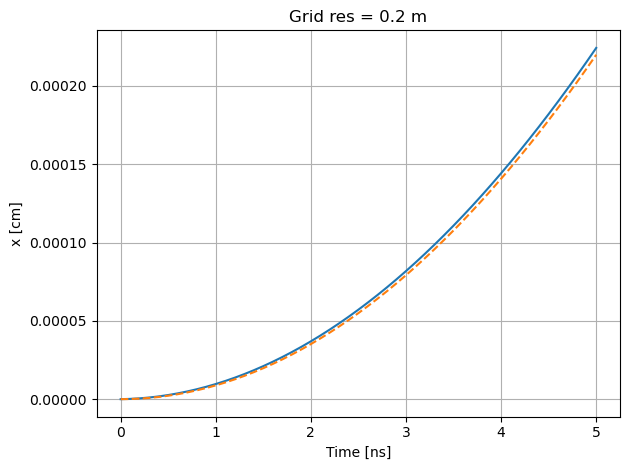

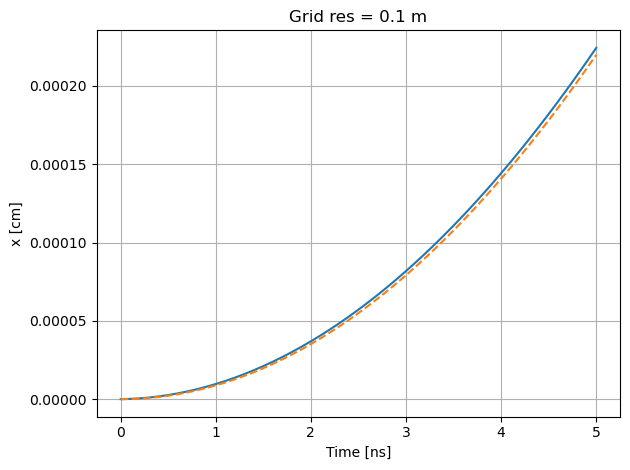

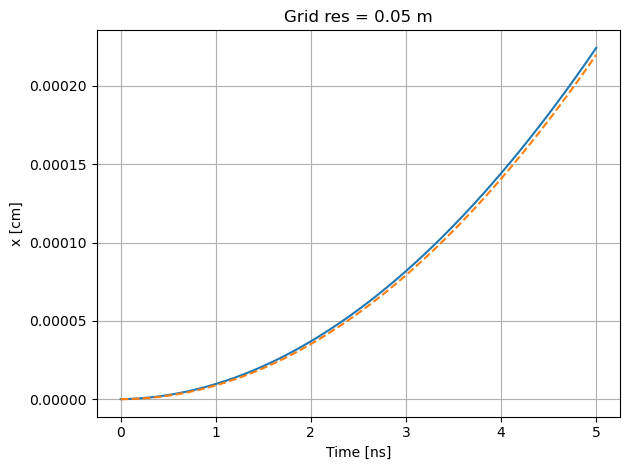

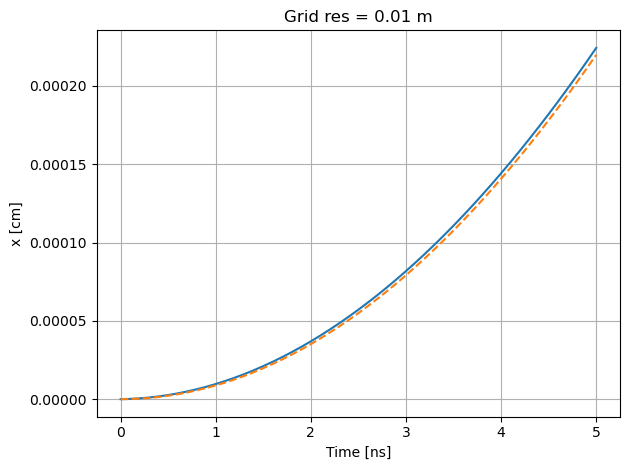

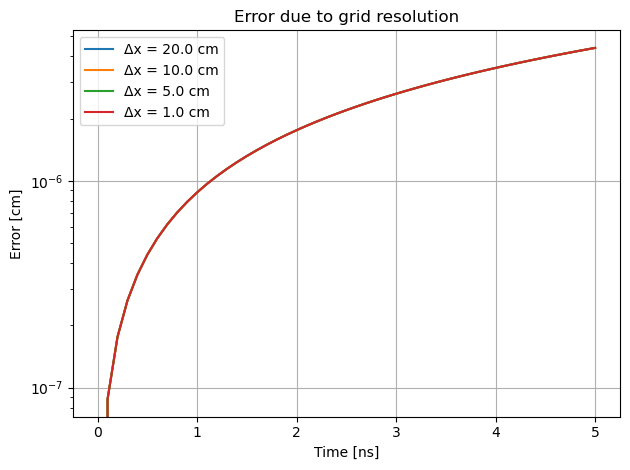

In [11]:
#+ pomiar czasu
E_ex = [-1,0,0]
B_ex = [0,0,0]
particles = Vector{Particle}(undef, 1)
p1 = Particle()
particles[1] = p1
p1.m = m_e
p1.q = q_e
p1.x = [0,0,0]
p1.v = [0,0,0]
Δt = 1e-10

dxs = [0.2, 0.1, 5e-2, 1e-2]
xerrors = [0.0]
for dx in dxs
    Δx = dx
    Δy = dx
    Δz = dx
    gsize, Ex, Ey, Ez, ρ, d, ϕ, ϕ_old = generate_grid(2,1,1, Δx,Δy,Δz)
    vel = []
    xx = []
    xx_an = []
    vel_an = []
    push!(vel, [0,0,0])
    push!(xx, [0,0,0])
    push!(vel_an, [0,0,0])
    push!(xx_an, [0,0,0])
    xerrors = [0.0]
    particles[1].x = [0,0,0]
    particles[1].v = [0,0,0]
    for i = 1:50
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
        push!(vel, particles[1].v)
        push!(xx, particles[1].x)
        va = (q_e/m_e) * E_ex * Δt*i
        xa = 0.5*(q_e/m_e) * E_ex * (Δt*i)^2
        push!(vel_an, va)
        push!(xx_an, xa)
    
        diff = particles[1].x .- xa
        er = sqrt(dot(diff, diff))
        push!(xerrors, er)
    end
    fig = plt.figure()
    plt.plot(0:0.1:5, [x[1]*100 for x in xx], linestyle="solid", label="simulation")
    plt.plot(0:0.1:5, [x[1]*100 for x in xx_an], linestyle="dashed", label="analytic")
    plt.grid()
    plt.xlabel("Time [ns]")
    plt.ylabel("x [cm]")
    plt.title("Grid res = $(dx) m")
    plt.tight_layout()
    plt.savefig("Eex_grid_$(dx).png")
end

history = []
fig = plt.figure()
xerrors = [0.0]
styles = [(0, (2, 6)),
(2, (2, 6)),
(4, (2, 6)),
(6, (2, 6))]
count = 0
for dx in dxs
    count += 1
    Δx = dx
    Δy = dx
    Δz = dx
    gsize, Ex, Ey, Ez, ρ, d, ϕ, ϕ_old = generate_grid(2,1,1, Δx,Δy,Δz)
    vel = []
    xx = []
    xx_an = []
    vel_an = []
    push!(vel, [0,0,0])
    push!(xx, [0,0,0])
    push!(vel_an, [0,0,0])
    push!(xx_an, [0,0,0])
    particles[1].x = [0,0,0]
    particles[1].v = [0,0,0]
    particles[1].q = q_e
    xerrors = [0.0]
    for i = 1:50
        timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
        push!(vel, particles[1].v)
        push!(xx, particles[1].x)
        va = (q_e/m_e) * E_ex * Δt*i
        xa = 0.5*(q_e/m_e) * E_ex * (Δt*i)^2
        push!(vel_an, va)
        push!(xx_an, xa)
    
        diff = (particles[1].x .- xa) .* 100
        er = sqrt(dot(diff, diff))
        push!(xerrors, er)
    end
    plt.plot(0:0.1:5.0, xerrors, linestyle=styles[count], label="Δx = $(dx*100) cm")
    push!(history, xerrors[1:10:end])
end

plt.xlabel("Time [ns]")
plt.ylabel("Error [cm]")
plt.title("Error due to grid resolution")
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig("Error_grid.png")
plt.yscale("log")
plt.tight_layout()
plt.savefig("Error_grid_lim.png")
println(xerrors)

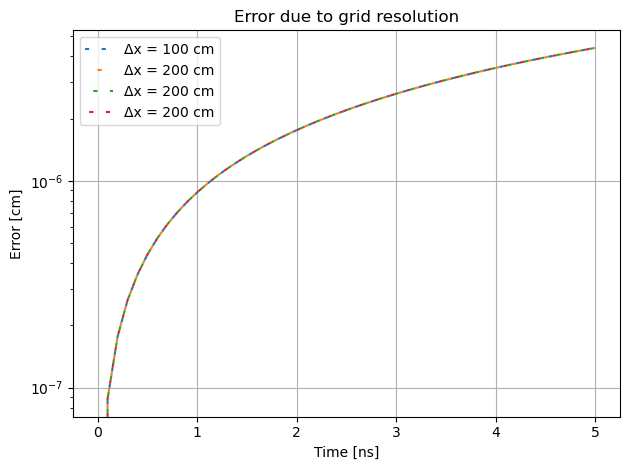

In [30]:
plt.plot(0:0.1:5.0, xerrors, linestyle=(0, (2, 6)), label="Δx = $(1*100) cm")
plt.plot(0:0.1:5.0, xerrors, linestyle=(2, (2, 6)), label="Δx = $(2*100) cm")
plt.plot(0:0.1:5.0, xerrors, linestyle=(4, (2,6)), label="Δx = $(2*100) cm")
plt.plot(0:0.1:5.0, xerrors, linestyle=(6, (2, 6)), label="Δx = $(2*100) cm")
plt.xlabel("Time [ns]")
plt.ylabel("Error [cm]")
plt.title("Error due to grid resolution")
plt.yscale("log")
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig("test.png")

In [37]:
q_e = -1.60217662e-19 # charge of electron C = A*s
m_e = 9.10938356e-31 # mass of electron kg
a = (q_e/m_e) * [-1,0,0]
time = 1:50
time *= 1e-10
vel_an = [a*t for t in time]
xx_an = [(a*t^2 / 2) for t in time]
pushfirst!(vel_an, [0,0,0])
pushfirst!(xx_an, [0,0,0])
;

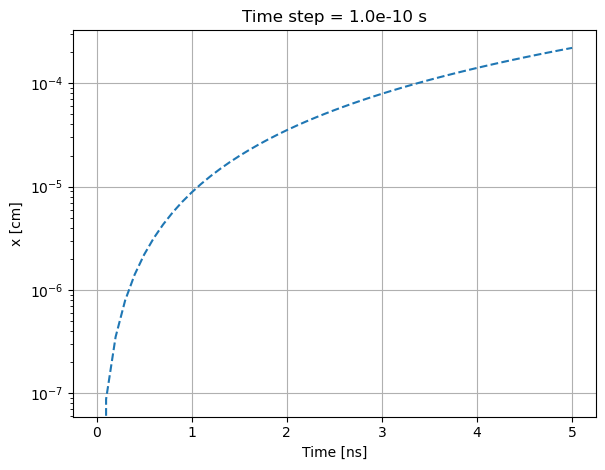

In [42]:
#plt.plot(0:0.1:5.0, [x[1]*100 for x in xx], linestyle="solid")
plt.plot(0:0.1:5.0, [x[1]*100 for x in xx_an], linestyle="dashed")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")
plt.title("Time step = $(Δt) s")
plt.tight_layout()
plt.savefig("aaaa.png")
plt.yscale("log")
plt.savefig("bbbb.png")

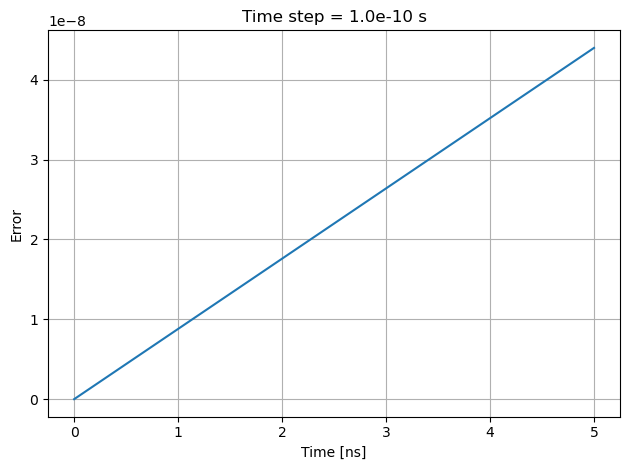

In [36]:
plt.plot(0:0.1:5.0, error, linestyle="solid")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("Error")
plt.title("Time step = $(Δt) s")
plt.tight_layout()
plt.savefig("Eex_step_$(Δt).png")

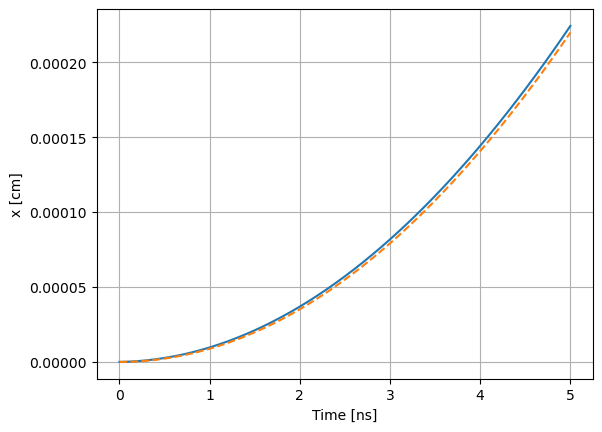

PyObject Text(24.0, 0.5, 'x [cm]')

In [19]:
plt.plot(0:0.1:5.0, [x[1]*100 for x in xx], linestyle="solid")
plt.plot(0:0.1:5.0, [x[1]*100 for x in xx_an], linestyle="dashed")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

In [ ]:
plt.plot(0:0.1:5.0, [x[1]*100 for x in xx_an], linestyle="dashed")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

In [23]:
#error9
diff = xx .- xx_an
error9 = [sqrt(dot(d,d)) for d in diff]

51-element Vector{Float64}:
 0.0
 8.794100113619811e-10
 1.7588200227239893e-9
 2.6382300340860243e-9
 3.5176400454480837e-9
 4.397050056810171e-9
 5.27646006817229e-9
 6.155870079534432e-9
 7.035280090896601e-9
 7.914690102258796e-9
 8.79410011362101e-9
 9.673510124983226e-9
 1.0552920136345467e-8
 ⋮
 3.4296990443136215e-8
 3.517640045449929e-8
 3.605581046586215e-8
 3.693522047722523e-8
 3.781463048858873e-8
 3.869404049995159e-8
 3.957345051131488e-8
 4.04528605226788e-8
 4.1332270534041875e-8
 4.221168054540474e-8
 4.3091090556768025e-8
 4.3970500568131735e-8

In [32]:
function compute_EK_particles(particles)
    ek = 0
    @inbounds for p in particles
        ek += m_e*dot(p.v,p.v)
    end
    ek = 0.5*ek*4.5e9 / (4096/(Δx*Δy*Δz))
    return ek
end

function compute_EP_field(Ex, Ey, Ez, Δx, Δy, Δz)
    ep = 0
    @inbounds for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
        ep += Ex[i,j,k]^2 + Ey[i,j,k]^2 + Ez[i,j,k]^2
    end
    ep = 0.5 * ε_0 * ep * Δx*Δy*Δz
    return ep
end

function compute_EP_potential(ρ, ϕ)
    ep = 0
    @inbounds for k = 1:(gsize[3]-1), j = 1:(gsize[2]-1), i = 1:(gsize[1]-1)
        ep += ρ[i,j,k] * ϕ[i,j,k]
    end
    ep = 0.5*ε_0*ep
    return ep
end

compute_EP_potential (generic function with 1 method)

In [31]:
function generate_particles!(particles, np)
    num = 2.2e6
    @inbounds for i = 1:np
        p1 = Particle()
        p1.x = [rand()*(gsize[1]-1)*Δx, rand()*(gsize[2]-1)*Δy, rand()*(gsize[3]-1)*Δz]
        p1.v = [5e5, 0, 0]
        p1.m = m_e*num
        p1.q = q_e*num
        p1.c = 1
        
        p2 = Particle()
        p2.x = [rand()*(gsize[1]-1)*Δx, rand()*(gsize[2]-1)*Δy, rand()*(gsize[3]-1)*Δz]
        p2.v = [-5e5, 0, 0]
        p2.m = m_e*num
        p2.q = q_e*num
        p2.c = 2
        push!(particles, p1)
        push!(particles, p2)       
    end

    @inbounds for i = 1:np*2
        p3 = Particle()
        p3.x = [rand()*(gsize[1]-1)*Δx, rand()*(gsize[2]-1)*Δy, rand()*(gsize[3]-1)*Δz]
        p3.v = [0, 0, 0]
        p3.m = m_e*num*2000
        p3.q = -q_e*num
        push!(particles, p3)
    end
end

generate_particles! (generic function with 1 method)

In [ ]:
#Two stream instability
E_ex = [0,0,0]
B_ex = [0,0,0]
np = 2048 #2048
particles = []
generate_particles!(particles, np)
Δt = 1e-9

historyxx = []
historyvel = []
EK = []
EE = []
EP = []

for i = 1:1000
    println(i)
    timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    if i % 25 == 0
        plt.figure()
        plt.scatter([p.x[1] for p in particles if p.c == 1], [p.v[1] for p in particles if p.c == 1], color="red", label="c = 1", s=2)
        plt.scatter([p.x[1] for p in particles if p.c == 2], [p.v[1] for p in particles if p.c == 2], color="blue", label="c = 2", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[p.x...] for p in particles])
        push!(historyvel, [[p.v...] for p in particles])
    end
    push!(EK, compute_EK_particles(particles))
    push!(EE, compute_EP_field(Ex, Ey, Ez, Δx, Δy, Δz))
    push!(EP, compute_EP_potential(ρ, ϕ))
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown



27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84

In [15]:
particles[1].v

3-element Vector{Float64}:
 500038.52993200626
    -12.743494692238247
    -15.111571065834447

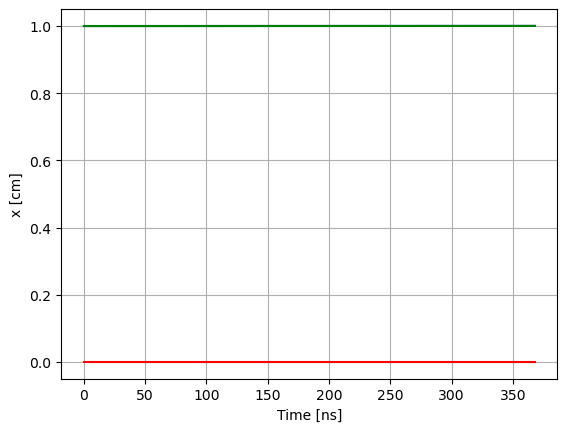

InterruptException: InterruptException:

In [ ]:
fig = plt.figure()
times = [1e9(i-1) * Δt for i=1:369]
plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

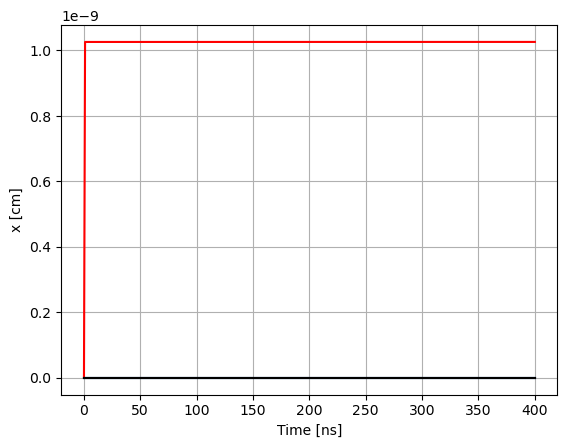

PyObject Text(24.000000000000007, 0.5, 'x [cm]')

In [17]:
fig = plt.figure()
plt.plot(0:400, EK, linestyle="solid", color="red")
plt.plot(0:400, EE, linestyle="solid", color="blue")
plt.plot(0:400, EP, linestyle="solid", color="green")
plt.plot(0:400, EE .+ EP, linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

In [ ]:
for i = 1
    println("B")
    println(i)
    timestep!(particles, ρ, d, ϕ, Ex,Ey,Ez,E_ex, B_ex,Δt, c)
    if i % 2 == 0
        plt.figure()
        plt.scatter([p.x[1] for p in particles if p.c == 1], [p.v[1] for p in particles if p.c == 1], color="red", label="c = 1")
        plt.scatter([p.x[1] for p in particles if p.c == 2], [p.v[1] for p in particles if p.c == 2], color="blue", label="c = 2")
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[p.x...] for p in particles])
        push!(historyvel, [[p.v...] for p in particles])
    end
end

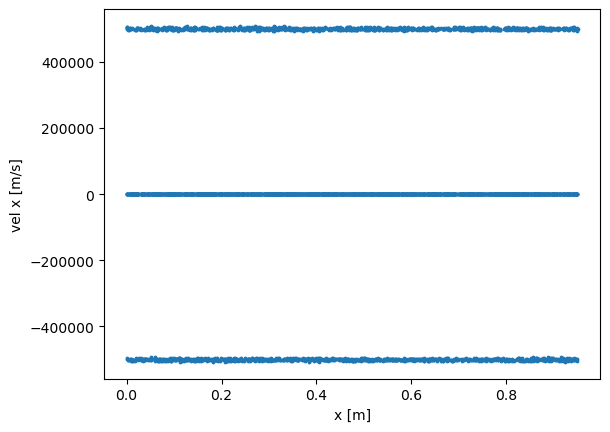

InterruptException: InterruptException:

In [ ]:
plt.figure()
plt.scatter([p.x[1] for p in particles], [p.v[1] for p in particles], s =3)
plt.xlabel("x [m]")
plt.ylabel("vel x [m/s]")
plt.show()

In [42]:
size(historyxx)

(40,)

MovieWriter ffmpeg unavailable; using Pillow instead.


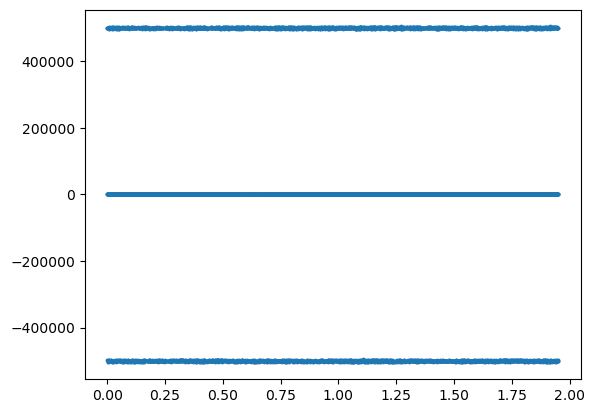

In [18]:
fig = plt.figure()
plt.scatter([p.x[1] for p in particles], [p.v[1] for p in particles], s =3)

function make_frame(i)
    plt.clf()
    plt.scatter([p[1] for p in historyxx[i+1]], [p[1] for p in historyvel[i+1]], s =3)
end

myanim = anim.FuncAnimation(fig, make_frame, frames=4, interval=200, blit=false)
myanim[:save]("test.gif", bitrate=-1)


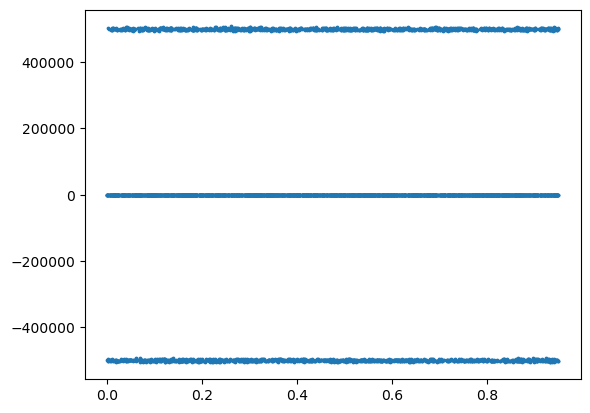

InterruptException: InterruptException:

In [ ]:
plt.scatter([p[1] for p in historyxx[14]], [p[1] for p in historyvel[14]], s =3)

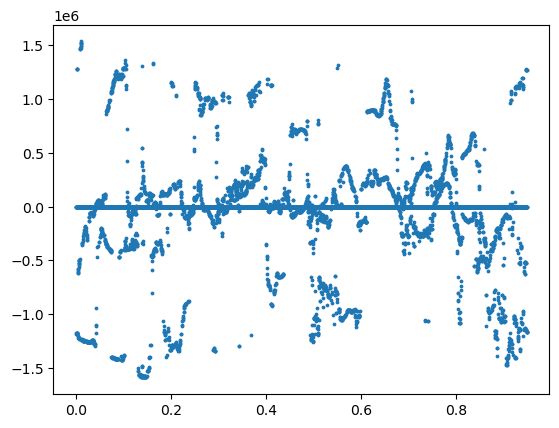

PyObject <matplotlib.collections.PathCollection object at 0x00000199615C6D40>

In [62]:
plt.scatter([p[1] for p in historyxx[1]], [p[1] for p in historyvel[1]], s =3)

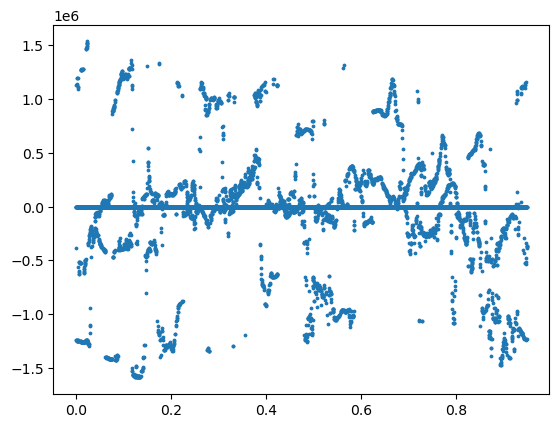

PyObject <matplotlib.collections.PathCollection object at 0x0000019961547220>

In [61]:
plt.scatter([p[1] for p in historyxx[2]], [p[1] for p in historyvel[2]], s =3)